## APPROACH:
### 1. Loading custom dataset
### 2. NLP pipeline for text preprocessing
### 3. Loading Glove embedding matrix
### 4. Converting sentences to vectors (creating the o/p of embedding layer)
### 5. Applying clustering algorithms
### 6. Data visualization and comparison

In [4]:
import re
import numpy as np 
import pandas as pd
# import seaborn as sns
# sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

# NLP
from nltk.tokenize.regexp import RegexpTokenizer
#from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

# import gensim
import spacy
import en_core_web_sm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

Using TensorFlow backend.


## Step 1: Load dataset

In [5]:
# from google.colab import files
# uploaded = files.upload()

In [9]:
# emails_df = pd.read_csv('./emails.csv', nrows=20000)
df = pd.read_csv('./emaildataset.csv')
print(df.shape)
df.head()

(951, 7)


,From,To,Subject,Body,Class,TransactionID,Payment Date
0,Spike@DEUTSCHEBANK.com,Shaniece@CitiBankPune.com,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending,72558,04-02-2020
1,Stacy@HDFC.com,Rohan@CitiBankNewYork.com,Order for new Cheque book,"Good morning, I want to place an order for an ...",General,212096,29-05-2020
2,Zachary@HDFC.com,Rishabh@CitiBankPune.com,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing,847047,26-01-2020
3,Stacy@SBI.com,Shai@CitiBankHongKong.com,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request,746078,17-06-2019
4,Angela@HDFC.com,Dipesh@CitiBankSingapore.com,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending,535918,18-02-2020


In [10]:
df.Class.unique()

array(['Pending', 'General', 'Processing', 'Request', 'Complete',
       'Failed'], dtype=object)

In [14]:
# from sklearn.cluster import KMeans

In [15]:

# kmeans  = KMeans(n_clusters=6)

In [16]:
# kmeans.fit(list(df.TransactionID),y)

In [17]:
# centers = kmeans.cluster_centers_

In [20]:
# plt.scatter(X[:,0],X[:,1])
# plt.scatter(centers[:,0],centers[:,1],marker='*',color='orange')
# plt.show()

ValueError: x and y must have same first dimension, but have shapes (6,) and (951,)

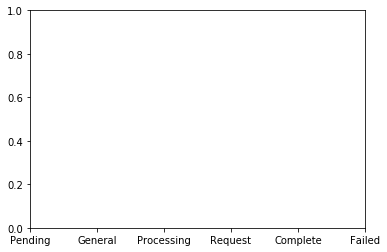

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
scores = [KMeans(n_clusters=i+2).fit(df).inertia_ 
          for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

## Step 2: NLP Pipeline for text preprocessing

In [0]:
nlp_ = en_core_web_sm.load()

In [0]:
nlp = spacy.load('en')

In [0]:
def clean(text):
    
    text=text.rstrip()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = " ".join([i for i in text.lower().split()])
    print(text)
    
    customize_stop_words = ["cc","subject","http", "gbp", "usd", "eur", "inr", "cad","thanks", "acc", "id", "account", "regards", "hi", "hello", "thank you", "greetings"]
    rem_stop = ["not", "wasn't", "hadn't", "won't", "can't", "didn't"]
    
    for w in customize_stop_words:
        nlp.vocab[w].is_stop = True
    
    for w in rem_stop:
        nlp.vocab[w].is_stop = False
    
    doc = nlp(text)
    
    normalized = " ".join(token.lemma_ for token in doc if not token.is_stop)
    
    doc = " ".join(token.orth_ for token in nlp(normalized) if not token.is_punct | token.is_space)

#     exclude = set(string.punctuation) 
#     lemma = WordNetLemmatizer()
#     porter= PorterStemmer()

    # AMOUNT EXTRACTION  NOT NEEDED
    #amount = "".join([i for i in text.lower().split() if i.isdigit()])
    
#     stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
#     punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
#     doc = lemma(punc_free)
    
#     normalized = " ".join(lemma(word) for token in punc_free.split())
#     stem = " ".join(porter.stem(token) for token in normalized.split())
#     return normalized, amount

#     return normalized
    return doc

In [8]:
print(clean("payment in id 1234 for amount 14859 GBP has been freezed"))

payment in id for amount gbp has been freezed
payment would freeze


In [0]:
for i in range(df.shape[0]):
    # merge subject and body strings
    df['Text_Data'] = (df['Subject'] + " " + df['Body'])

In [0]:
def converter(x):
    try:
        return ' '.join([x.lower() for x in str(x).split()])
    except AttributeError:
        return None  # or some other value

df['Text_Data'] = df['Text_Data'].apply(converter)

In [11]:
df.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date,Text_Data
0,Spike@DEUTSCHEBANK.com,Shaniece@CitiBankPune.com,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending,72558,04-02-2020,transaction no. 072558 is unresolved. sorry to...
1,Stacy@HDFC.com,Rohan@CitiBankNewYork.com,Order for new Cheque book,"Good morning, I want to place an order for an ...",General,212096,29-05-2020,"order for new cheque book good morning, i want..."
2,Zachary@HDFC.com,Rishabh@CitiBankPune.com,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing,847047,26-01-2020,required money acquired. transaction 847047 is...
3,Stacy@SBI.com,Shai@CitiBankHongKong.com,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request,746078,17-06-2019,asking for the details for transaction 746078 ...
4,Angela@HDFC.com,Dipesh@CitiBankSingapore.com,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending,535918,18-02-2020,partial payment for transaction 535918 hello!!...


In [12]:
# sub_df["content"]=sub_df["content"].map(clean)
for i in range(df.shape[0]):
    df.loc[i]['Text_Data'] = clean(df.loc[i]['Text_Data'])

transaction no is unresolved sorry to inform that there has been only a partial payment of amount gbp you are definitely going to receive the rest at a later point of time warm regards
order for new cheque book good morning i want to place an order for an multicity cheque book for account no having atleat leaves kindly send the same to the address mentioned in my account records
required money acquired transaction is in process hello this is to inform you that i have received the amount you transferred to my account and now it is currently in process
asking for the details for transaction i request you to kindly send the status of my transaction with id thanks and regards
partial payment for transaction hello greetings for the day status of transaction usd for account is pending i would be grateful if you could tell me the cause thanks a lot
payment done and transaction settled greetings i wanted to let you know that i have acknowledged the payment for transaction in response to your e

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


the pending amount for transaction will reach you soon since my transaction is still pending i wanted to know if there is a problem with the paperwork from my side please let me know at the earliest thanks and regards
handling the transaction after payment sincere greetings i am glad to tell you that i have finally been granted the pre approved amount through transaction it is now being processed i am grateful for your support warm regards
upgrade to an account with more benefits hello greetings for the day so i have an account with your branch having no and i have recently seen an advertisement which states that if i become a premium customer i can avail many benefits i have decided to upgrade my account can you please guide me through the steps to be taken in order to do this i would be very grateful if you reply within days thank you
processing transaction having id acknowledging the received payment for transaction it is finally in process i am appreciative of your efforts kind reg

In [13]:
df.head()

,From,To,Subject,Body,Class,TransactionID,Payment Date,Text_Data
0,Spike@DEUTSCHEBANK.com,Shaniece@CitiBankPune.com,Transaction no. 072558 is unresolved.,Sorry to inform that there has been only a par...,Pending,72558,04-02-2020,transaction no. 072558 is unresolved. sorry to...
1,Stacy@HDFC.com,Rohan@CitiBankNewYork.com,Order for new Cheque book,"Good morning, I want to place an order for an ...",General,212096,29-05-2020,"order for new cheque book good morning, i want..."
2,Zachary@HDFC.com,Rishabh@CitiBankPune.com,Required money acquired. Transaction 847047 is...,Hello! This is to inform you that I have recei...,Processing,847047,26-01-2020,required money acquired. transaction 847047 is...
3,Stacy@SBI.com,Shai@CitiBankHongKong.com,Asking for the details for transaction 746078,I request you to kindly send the status of my ...,Request,746078,17-06-2019,asking for the details for transaction 746078 ...
4,Angela@HDFC.com,Dipesh@CitiBankSingapore.com,Partial payment for transaction 535918,Hello!! Greetings for the day. Status of trans...,Pending,535918,18-02-2020,partial payment for transaction 535918 hello!!...


In [14]:
df['Text_Data'][0]

'transaction no. 072558 is unresolved. sorry to inform that there has been only a partial payment of amount gbp 908225. you are definitely going to receive the rest at a later point of time. warm regards.'

In [0]:
# Calculating optimal sentence length according to Gaussian distribution

lengths = []

for i in range(df.shape[0]):
    words = df.values[i][7].split()
    lengths.append(len(words))
    
avg = int(np.mean(lengths) + 2*np.std(lengths))

In [0]:
# df['Subject'][1005] + " " + df['Body'][1005]

## Step 3: Loading word2vec

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip 

--2020-06-13 20:15:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-06-13 20:15:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-06-13 20:15:34--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [18]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [19]:
!ls
!pwd

emaildataset.csv   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [20]:
embeddings_index = {}
with open('glove.6B.300d.txt',encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:],dtype='float32')
        
#         print(word)
#         print(coeffs)
        embeddings_index[word] = coeffs
    f.close()
print(len(embeddings_index))

# embeddings_index = dict()
# f = open('./glove.6B.300d.txt')
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

400000


In [21]:
print(len(embeddings_index))
print(len(embeddings_index['girl']))

400000
300


## Step 4: Converting sentences to vectors (creating the o/p of embedding layer)

In [22]:
t = Tokenizer()
l = list(df.Text_Data)
t.fit_on_texts(l)
vocab_size = len(t.word_index) + 1
print(vocab_size)

# integer encode the mails
encoded_mails = t.texts_to_sequences(l)

#post padding
padded_inputs = pad_sequences(encoded_mails, maxlen=avg, padding='post')
# print(padded_inputs)

1545


In [23]:

padded_inputs.shape

(952, 53)

In [24]:
# create a weight matrix for words in training docs

print(encoded_mails[0])
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
#         print(i)
#         print(word)
#         print()
embedding_matrix[0] 

[2, 26, 909, 7, 226, 910, 4, 49, 12, 127, 23, 65, 114, 16, 94, 15, 9, 18, 227, 911, 6, 272, 108, 912, 4, 303, 1, 129, 75, 16, 164, 913, 9, 304, 80, 14]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [25]:
embedding_matrix.shape

(1545, 300)

## Embedding matrix train

In [0]:
def getOutputEmbeddings(X):
    embedding_matrix_output = np.zeros((X.shape[0],avg,300))
    
    for ix in range(X.shape[0]):
#         X[ix] = X[ix].split()
        for jx in range(len(X[ix])):
#             if X[ix][jx] in embeddings:
            embedding_matrix_output[ix][jx] = embedding_matrix[X[ix][jx]]
            
    return embedding_matrix_output

In [27]:
embedding_matrix_output = getOutputEmbeddings(padded_inputs)
embedding_matrix_output.shape

(952, 53, 300)

In [0]:
embedding_matrix_output = embedding_matrix_output.reshape(df.shape[0], -1)

In [0]:
# import preprocessing from sklearn
# from sklearn.preprocessing import OneHotEncoder 
# from sklearn.preprocessing import LabelEncoder 

In [0]:
# le = OneHotEncoder()
# classes = df['Class'].values

# classes = classes.reshape(-1, 1)
# Y = le.fit_transform(classes)

In [0]:
# Y = Y.toarray()

In [0]:
Y = list(df['Class'])

In [0]:
# X_train, X_test, Y_train, Y_test = train_test_split(embedding_matrix_output, Y, test_size=0.2, stratify=Y)
X_train, X_test, Y_train, Y_test = train_test_split(embedding_matrix_output, Y, test_size=0.2, stratify=Y)

In [0]:
# Y_test.unique()

## Step 5: Applying ML algorithms

### Support Vector Machine

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [0]:
import multiprocessing

In [37]:
cpus = multiprocessing.cpu_count()
print(cpus)

2


In [0]:
params = [
    {
        'kernel':['linear','rbf','poly','sigmoid'],
        'C':[0.1,0.2,0.5,1.0,2.0,5.0]
    }   
]

In [39]:
svc = svm.SVC()
svc.fit(X_train,Y_train)
svc.score(X_test, Y_test)

0.9947643979057592

In [40]:
cross_val_score(svc,embedding_matrix_output, Y, scoring="accuracy",cv=5).mean()

0.9853292918159273

In [0]:
# gs = GridSearchCV(estimator=svm.SVC(),param_grid=params,scoring="accuracy",cv=5,n_jobs = cpus)

# gs.fit(embedding_matrix_output, Y)

In [0]:
# gs.best_estimator_
# gs.best_score_

In [0]:
y_pred = svc.predict(X_test)

In [44]:
classification_report(Y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')

'              precision    recall  f1-score   support\n\n    Complete       1.00      0.97      0.98        32\n      Failed       1.00      1.00      1.00        36\n     General       1.00      1.00      1.00        24\n     Pending       0.97      1.00      0.99        34\n  Processing       1.00      1.00      1.00        31\n     Request       1.00      1.00      1.00        34\n\n    accuracy                           0.99       191\n   macro avg       1.00      0.99      0.99       191\nweighted avg       0.99      0.99      0.99       191\n'

### Bernoulli Naive Bayes algorithm

In [0]:
from sklearn.naive_bayes import BernoulliNB

In [46]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, Y_train)
BNBmodel.score(X_test, Y_test)

0.7958115183246073

In [0]:
y_pred = svc.predict(X_test)

In [48]:
classification_report(Y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')

'              precision    recall  f1-score   support\n\n    Complete       1.00      0.97      0.98        32\n      Failed       1.00      1.00      1.00        36\n     General       1.00      1.00      1.00        24\n     Pending       0.97      1.00      0.99        34\n  Processing       1.00      1.00      1.00        31\n     Request       1.00      1.00      1.00        34\n\n    accuracy                           0.99       191\n   macro avg       1.00      0.99      0.99       191\nweighted avg       0.99      0.99      0.99       191\n'

### Random forest algorithm

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
clf = RandomForestClassifier()
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
clf.score(X_test, Y_test)

0.9947643979057592

In [0]:
y_pred = clf.predict(X_test)

In [53]:
classification_report(Y_test, y_pred, labels=None, target_names=None, sample_weight=None, digits=2, output_dict=False, zero_division='warn')

'              precision    recall  f1-score   support\n\n    Complete       1.00      1.00      1.00        32\n      Failed       0.97      1.00      0.99        36\n     General       1.00      0.96      0.98        24\n     Pending       1.00      1.00      1.00        34\n  Processing       1.00      1.00      1.00        31\n     Request       1.00      1.00      1.00        34\n\n    accuracy                           0.99       191\n   macro avg       1.00      0.99      0.99       191\nweighted avg       0.99      0.99      0.99       191\n'

## Step 6: Visualise our results

In [0]:
# import matplotlib.pyplot as plt